# Pretrain Auditory Perceptual Distance (APD) model
July 12th, 2024

*Chen, S., Thielk, M., & Gentner, T. Q. (2024). Auditory Feature-based Perceptual Distance. bioRxiv, 2024.02.28.582631. https://doi.org/10.1101/2024.02.28.582631*

### Overview of Auditory Feature-based Perceptual Distance (APD):
1. Convert audio files to species-specific frequency scaled spectrogram 
2. Pre-train convolutional neural network (CNN) to learn spectrogram features **(You are here!)**
    - Import Spectrograms
    

3. Fine-tune CNN with behavioral data

In [1]:
## import file tools

In [2]:
import datetime
import sys
import os

## import general data science tools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle

## import machine learning tools

In [4]:
import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
tf.compat.v1.disable_eager_execution()

2024-07-15 12:46:18.622274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 12:46:18.622358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 12:46:18.629420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

## import Kai's custom functions

In [6]:
from apd.utils.trainingfuncs import *
from apd.utils.math_utils import *

# Load data

### Load data from starling stable_length

In [7]:
sys.path.append("..") # Adds higher directory to python modules path.
from apd.helpers.dataset_vars import *
from apd.helpers.SoundWav import *

In [8]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [9]:
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [10]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [11]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [12]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [13]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [100]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [15]:
spec_list = spec_df.spec.values.tolist()

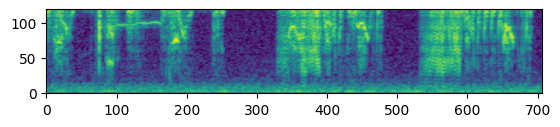

In [16]:
plt.imshow(spec_list[0][:120,:], origin='lower')

In [17]:
subj_list = spec_df.name.values.tolist()

In [18]:
n_slices = (4, 1)

In [19]:
len(spec_df) ## 500 exemplars for 14 subjects

7000

## sanity check

In [44]:
from apd.utils.paths import ZENODO_DIR, DATA_DIR

In [45]:
import glob

In [47]:
segs = glob.glob(os.path.join(DATA_DIR, 'interim', 'stable_length', '*', '*.wav'))

In [61]:
test_audio = segs[0]

In [62]:
test_audio

'/mnt/cube/j8xing/kai_apd/data/interim/stable_length/B335/2008-05-12_20-38-00-000000-1766756-1933895.wav'

##### following step of http://localhost:8892/notebooks/kai/repositories/star_scale/1.0_make_spectrograms_star.ipynb

In [63]:
y, sr = librosa.load(test_audio, sr = None)

In [66]:
len(y) / sr ## this is the canonical length for this segment

3.79

In [67]:
librosa.get_duration(y = y, sr = sr)

3.79

In [69]:
spec_pars = {'fft_size': 2048, 
             'step_size': 256,
             'n_stars':int(hz2star(44100/2)),
             'fmin': 20}

In [70]:
S_star = star_spectrogram(y=y, sr=sr, n_stars=spec_pars['n_stars'], n_fft=spec_pars['fft_size'], 
                                      hop_length=spec_pars['step_size'], win_length=spec_pars['fft_size'], 
                                      window='hann')

In [99]:
librosa.get_duration(
    S = S_star, 
    sr = 44100,
    n_fft = spec_pars['n_stars'], 
    hop_length = spec_pars['step_size'],
    center = True
)

3.784875283446712

#### try on our dataset

In [324]:
input_list = []
output_list = []

for spec in spec_list[:1]: ## output only one segment
    for i in range(1):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, slice_shape=(55, 224))
        input_list.append(slice_list)
        output_list.append(index_list)

/tmp/ipykernel_3679372/2434957.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)],


In [325]:
np.array(input_list).shape

(1, 4, 55, 224, 3)

In [326]:
np.array(output_list).shape

(1, 4)

In [327]:
test_input = np.transpose(input_list, (4, 0, 1, 2, 3))

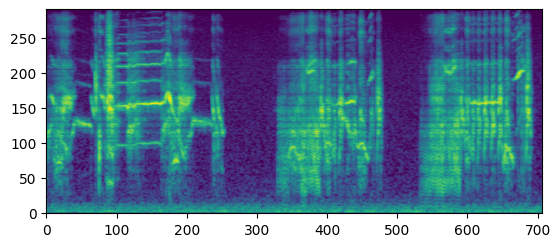

In [328]:
plt.imshow(spec_list[0], origin = 'lower')

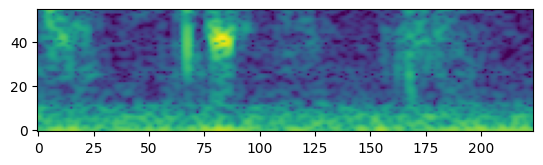

In [329]:
plt.imshow(test_input[0][0][0], origin='lower')

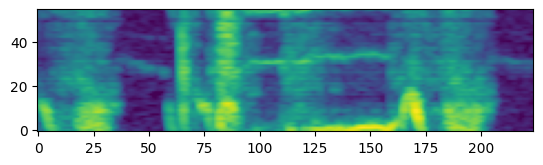

In [330]:
plt.imshow(test_input[0][0][1], origin='lower')

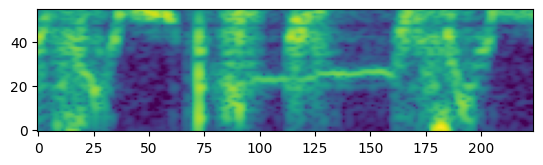

In [331]:
plt.imshow(test_input[0][0][2], origin='lower')

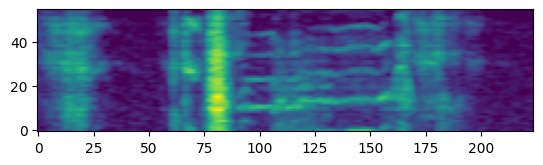

In [332]:
plt.imshow(test_input[0][0][3], origin='lower')

In [333]:
output_list ## this list shows the index of how the spectrograms should be reassembled from bottom to top

[array([0., 2., 1., 3.])]

In [336]:
test_input[0][0][3].shape

(55, 224)

In [338]:
librosa.get_duration(
    S = test_input[0][0][3],
    sr = 44100,
    n_fft = spec_pars['n_stars'], 
    hop_length = spec_pars['step_size'],
    center = True
)

1.2945351473922901